## Interval Analysis

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.view((-1, 28*28)) # implemented in the analysis function
        x = self.relu(self.fc(x))
        x = self.fc2(x)
        x = self.softmax(x) # added softmax for probabilities
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=-1)
  )
)

In [2]:
def train_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy on images: {100 * correct / total}')

In [3]:
train_model(model, 15)
test_model(model)

Epoch 1/15, Loss: 2.012
Epoch 2/15, Loss: 1.729
Epoch 3/15, Loss: 1.627
Epoch 4/15, Loss: 1.596
Epoch 5/15, Loss: 1.582
Epoch 6/15, Loss: 1.572
Epoch 7/15, Loss: 1.566
Epoch 8/15, Loss: 1.561
Epoch 9/15, Loss: 1.557
Epoch 10/15, Loss: 1.553
Epoch 11/15, Loss: 1.550
Epoch 12/15, Loss: 1.547
Epoch 13/15, Loss: 1.545
Epoch 14/15, Loss: 1.542
Epoch 15/15, Loss: 1.540
Accuracy on images: 93.43


### Write the interval analysis for the simple model.

 Implement interval analysis for your network. Use this to measure the robustness for the whole test set of your network for 10 l∞ neighborhoods, sized evenly between 0.01 and 0.1 (inclusive). Report the verified accuracy (the percentage of the images that are successfully verified) for those different values chosen. As usual, present your observations clearly along with experimental evidence (numbers, images, etc.) in your submission.

In [4]:
!pip install bound-propagation

import bound_propagation as bp
from bound_propagation import IntervalBounds

# --- INTERVAL ANALYSIS SETUP ---

# 1. Create Verification Model and Transfer Weights
# This model uses the same layers but outputs raw LOGITS for verification.
class LogitNet(nn.Module):
    def __init__(self):
        super(LogitNet, self).__init__()
        # Use standard nn.Linear and ReLU modules
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
        self.relu = nn.ReLU()
        # Softmax is omitted for logit analysis

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = self.relu(self.fc(x))
        x = self.fc2(x)
        return x

verification_model = nn.Sequential(Normalize(), LogitNet())
verification_model.to(device)

# Transfer weights from the TRAINED model (model) to the verification_model
with torch.no_grad():
    # model[1] is the trained Net, verification_model[1] is the LogitNet
    verification_model[1].fc.weight.data.copy_(model[1].fc.weight.data)
    verification_model[1].fc.bias.data.copy_(model[1].fc.bias.data)
    verification_model[1].fc2.weight.data.copy_(model[1].fc2.weight.data)
    verification_model[1].fc2.bias.data.copy_(model[1].fc2.bias.data)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.3 MB/s eta 0:00:00


In [5]:
# --- 2. Interval Propagation Function (Standard IBP Equations) ---
def get_interval_bounds(model, x, epsilon):
    """
    Performs manual Interval Bound Propagation (IBP) reflecting the
    Linear -> ReLU -> Linear architecture.
    """

    # 1. Calculate and Normalize Bounds on TENSORS
    L = x - epsilon
    U = x + epsilon
    L = torch.clamp(L, 0, 1)
    U = torch.clamp(U, 0, 1)

    mean, std = 0.1307, 0.3081
    L_norm = (L - mean) / std
    U_norm = (U - mean) / std

    net = model[1] # This is the LogitNet module

    # 2. Manual View Operation (Flattening)
    L_flat = L_norm.view((-1, 28*28))
    U_flat = U_norm.view((-1, 28*28))

    # --- Layer 1: fc (Linear) ---
    # Equation: L = W_pos * L + W_neg * U + b
    W1, b1 = net.fc.weight, net.fc.bias
    W1_pos = F.relu(W1)
    W1_neg = -F.relu(-W1)

    L1 = F.linear(L_flat, W1_pos, None) + F.linear(U_flat, W1_neg, b1)
    U1 = F.linear(U_flat, W1_pos, None) + F.linear(L_flat, W1_neg, b1)

    # --- Layer 2: ReLU ---
    # Equation: ReLU(L, U) = [ReLU(L), ReLU(U)]
    L2 = F.relu(L1)
    U2 = F.relu(U1)

    # --- Layer 3: fc2 (Linear) ---
    W2, b2 = net.fc2.weight, net.fc2.bias
    W2_pos = F.relu(W2)
    W2_neg = -F.relu(-W2)

    L_final = F.linear(L2, W2_pos, None) + F.linear(U2, W2_neg, b2)
    U_final = F.linear(U2, W2_pos, None) + F.linear(L2, W2_neg, b2)

    return L_final, U_final


# --- 3. Robustness Verification Function ---
def verify_robustness(model, test_loader, epsilon):
    model.eval()
    verified_count = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Use the original model for clean prediction (it outputs probabilities/softmax)
            clean_probs = model(images)
            _, predicted_labels = torch.max(clean_probs, 1)

            # Get interval bounds (L, U are on logits from the verification_model)
            L, U = get_interval_bounds(model, images, epsilon)

            for j in range(images.size(0)):
                total_samples += 1
                true_label = labels[j]
                predicted_label = predicted_labels[j]

                # Only verify correctly classified samples
                if true_label.item() == predicted_label.item():
                    L_true = L[j, predicted_label]

                    # Find max upper bound of all incorrect classes
                    incorrect_indices = torch.arange(10).to(device) != predicted_label
                    U_other_max = torch.max(U[j, incorrect_indices])

                    # Robustness condition: L_true > max(U_other)
                    if L_true > U_other_max:
                        verified_count += 1

    verified_accuracy = (verified_count / len(test_loader.dataset)) * 100
    return verified_accuracy


In [6]:
# HW3 Question 2, part a

def ibp_loss(model, x, y, epsilon_train, kappa):
    """
    Compute IBP loss following the paper's formulation:
    L_IBP = κ·CE(z_K, y_true) + (1-κ)·CE(ẑ_K(ε_train), y_true)
    """
    logits = model(x)
    ce_loss = F.cross_entropy(logits, y)

    if kappa == 1.0:
        return ce_loss

    L_bounds, U_bounds = get_interval_bounds(model, x, epsilon_train)
    batch_size = x.size(0)
    L_true = L_bounds[torch.arange(batch_size), y]

    mask = torch.ones_like(L_bounds).bool()
    mask[torch.arange(batch_size), y] = False

    U_incorrect = U_bounds.clone()
    U_incorrect[~mask] = float('-inf')
    U_max_incorrect = U_incorrect.max(dim=1)[0]

    robust_loss = F.relu(U_max_incorrect - L_true).mean()
    total_loss = kappa * ce_loss + (1 - kappa) * robust_loss

    return total_loss


def train_ibp_model(model, train_loader, epochs=20,
                     start_eps=0.0, target_eps=0.1,
                     start_kappa=1.0, end_kappa=0.5,
                     lr=0.001):
    """
    Train with IBP using gradual schedules for epsilon and kappa
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"Training IBP model for {epochs} epochs")
    print(f"Epsilon schedule: {start_eps} -> {target_eps}")
    print(f"Kappa schedule: {start_kappa} -> {end_kappa}")

    training_start = time.time()

    for epoch in range(epochs):
        model.train()

        eps_schedule = start_eps + (target_eps - start_eps) * (epoch / epochs)
        kappa_schedule = start_kappa + (end_kappa - start_kappa) * (epoch / epochs)

        total_loss = 0
        correct = 0
        total = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            # compute IBP loss
            loss = ibp_loss(model, x_batch, y_batch, eps_schedule, kappa_schedule)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                logits = model(x_batch)
                pred = logits.argmax(dim=1)
                correct += (pred == y_batch).sum().item()
                total += y_batch.size(0)

            total_loss += loss.item() * y_batch.size(0)

        avg_loss = total_loss / total
        train_acc = correct / total

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={train_acc:.4f}, "
              f"eps={eps_schedule:.4f}, kappa={kappa_schedule:.2f}")

    training_time = time.time() - training_start
    print(f"\nTotal training time: {training_time:.2f} seconds")

    return training_time


def test_pgd_robustness(model, test_loader, eps=0.1, alpha=0.01, steps=40):
    """Test robust accuracy using PGD attack"""
    model.eval()
    correct = 0
    total = 0

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # PGD attack
        x_adv = x.clone().detach()
        x_adv = torch.clamp(x_adv + torch.zeros_like(x_adv).uniform_(-eps, eps), 0, 1)

        for _ in range(steps):
            x_adv.requires_grad = True
            outputs = model(x_adv)
            loss = F.cross_entropy(outputs, y)

            grad = torch.autograd.grad(loss, x_adv)[0]
            x_adv = x_adv.detach() + alpha * grad.sign()
            x_adv = torch.min(torch.max(x_adv, x - eps), x + eps)
            x_adv = torch.clamp(x_adv, 0, 1)

        with torch.no_grad():
            outputs = model(x_adv)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    acc = 100 * correct / total
    print(f'PGD Robust Accuracy (eps={eps}): {acc:.2f}%')
    return acc


# train IBP model
print("\n--- Training IBP Model ---")
model_ibp = nn.Sequential(Normalize(), LogitNet()).to(device)
time_ibp = train_ibp_model(model_ibp, train_loader, epochs=20,
                            start_eps=0.0, target_eps=0.1,
                            start_kappa=1.0, end_kappa=0.5,
                            lr=0.001)

print("\n--- Evaluating IBP Model ---")
test_model(model_ibp)
acc_ibp_robust = test_pgd_robustness(model_ibp, test_loader, eps=0.1)

print("\n--- Comparing with Standard Model (already trained) ---")
print("Standard model was already trained at the beginning")
test_model(model)
acc_std_robust = test_pgd_robustness(verification_model, test_loader, eps=0.1)

print(f"Training time for IBP: {time_ibp:.2f} seconds")


--- Training IBP Model ---
Training IBP model for 20 epochs
Epsilon schedule: 0.0 -> 0.1
Kappa schedule: 1.0 -> 0.5
Epoch 1: Loss=0.2367, Acc=0.9382, eps=0.0000, kappa=1.00
Epoch 2: Loss=0.1023, Acc=0.9755, eps=0.0050, kappa=0.97
Epoch 3: Loss=0.0804, Acc=0.9847, eps=0.0100, kappa=0.95
Epoch 4: Loss=0.0789, Acc=0.9872, eps=0.0150, kappa=0.93
Epoch 5: Loss=0.0781, Acc=0.9896, eps=0.0200, kappa=0.90
Epoch 6: Loss=0.0812, Acc=0.9903, eps=0.0250, kappa=0.88
Epoch 7: Loss=0.0860, Acc=0.9907, eps=0.0300, kappa=0.85
Epoch 8: Loss=0.0927, Acc=0.9902, eps=0.0350, kappa=0.82
Epoch 9: Loss=0.1006, Acc=0.9896, eps=0.0400, kappa=0.80
Epoch 10: Loss=0.1099, Acc=0.9887, eps=0.0450, kappa=0.78
Epoch 11: Loss=0.1202, Acc=0.9874, eps=0.0500, kappa=0.75
Epoch 12: Loss=0.1301, Acc=0.9867, eps=0.0550, kappa=0.72
Epoch 13: Loss=0.1399, Acc=0.9858, eps=0.0600, kappa=0.70
Epoch 14: Loss=0.1509, Acc=0.9843, eps=0.0650, kappa=0.68
Epoch 15: Loss=0.1625, Acc=0.9824, eps=0.0700, kappa=0.65
Epoch 16: Loss=0.1724,


--- Testing IBP-Trained Model ---
Epsilon=0.010: Verified Accuracy: 95.78%
Epsilon=0.020: Verified Accuracy: 94.75%
Epsilon=0.030: Verified Accuracy: 93.36%
Epsilon=0.040: Verified Accuracy: 91.55%
Epsilon=0.050: Verified Accuracy: 89.08%
Epsilon=0.060: Verified Accuracy: 86.12%
Epsilon=0.070: Verified Accuracy: 82.52%
Epsilon=0.080: Verified Accuracy: 78.56%
Epsilon=0.090: Verified Accuracy: 73.52%
Epsilon=0.100: Verified Accuracy: 65.98%

--- Testing Standard Model (for comparison) ---
Epsilon=0.010: Verified Accuracy: 49.59%
Epsilon=0.020: Verified Accuracy: 5.30%
Epsilon=0.030: Verified Accuracy: 0.20%
Epsilon=0.040: Verified Accuracy: 0.00%
Epsilon=0.050: Verified Accuracy: 0.00%
Epsilon=0.060: Verified Accuracy: 0.00%
Epsilon=0.070: Verified Accuracy: 0.00%
Epsilon=0.080: Verified Accuracy: 0.00%
Epsilon=0.090: Verified Accuracy: 0.00%
Epsilon=0.100: Verified Accuracy: 0.00%


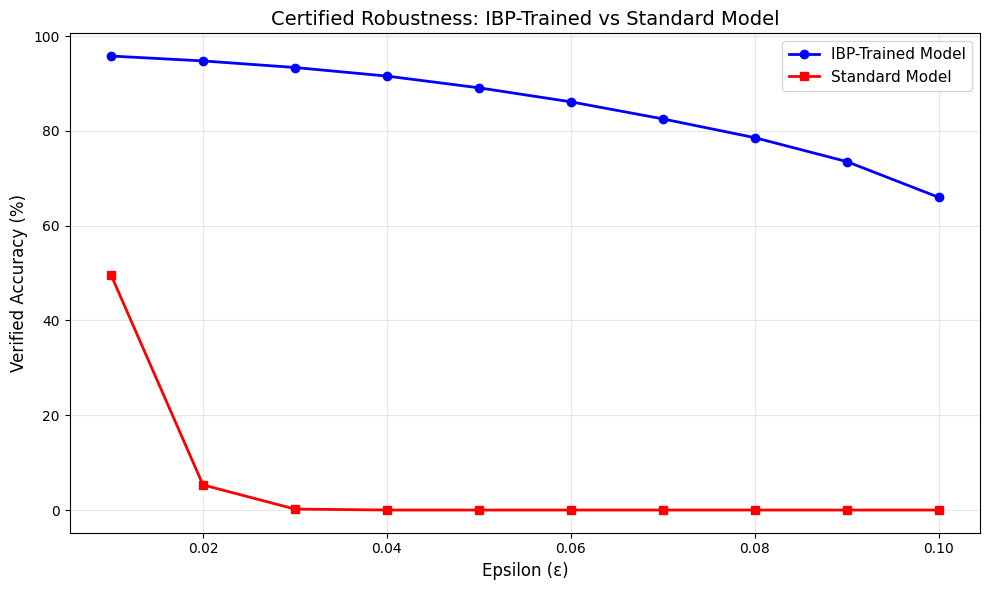

Epsilon      Standard Model     IBP Model          Improvement    
--------------------------------------------------------------------------------
0.010        49.59              95.78              +46.19
0.020        5.30               94.75              +89.45
0.030        0.20               93.36              +93.16
0.040        0.00               91.55              +91.55
0.050        0.00               89.08              +89.08
0.060        0.00               86.12              +86.12
0.070        0.00               82.52              +82.52
0.080        0.00               78.56              +78.56
0.090        0.00               73.52              +73.52
0.100        0.00               65.98              +65.98


In [9]:
# HW3 Question 2, part b

def verify_robustness_ibp_model(model, test_loader, epsilon):
    """
    Use the verification code from HW-2 to test certified robustness
    This is YOUR existing verify_robustness function!
    """
    model.eval()
    verified_count = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            clean_probs = model(images)
            _, predicted_labels = torch.max(clean_probs, 1)

            L, U = get_interval_bounds(model, images, epsilon)

            for j in range(images.size(0)):
                total_samples += 1
                true_label = labels[j]
                predicted_label = predicted_labels[j]

                if true_label.item() == predicted_label.item():
                    L_true = L[j, predicted_label]

                    incorrect_indices = torch.arange(10).to(device) != predicted_label
                    U_other_max = torch.max(U[j, incorrect_indices])

                    if L_true > U_other_max:
                        verified_count += 1

    verified_accuracy = (verified_count / len(test_loader.dataset)) * 100
    return verified_accuracy

epsilons = np.linspace(0.01, 0.1, 10)
verified_accuracies_ibp = []
verified_accuracies_standard = []

print("\n--- Testing IBP-Trained Model ---")
for epsilon in epsilons:
    verified_acc = verify_robustness_ibp_model(model_ibp, test_loader, epsilon)
    verified_accuracies_ibp.append(verified_acc)
    print(f"Epsilon={epsilon:.3f}: Verified Accuracy: {verified_acc:.2f}%")

print("\n--- Testing Standard Model (for comparison) ---")
for epsilon in epsilons:
    verified_acc = verify_robustness_ibp_model(verification_model, test_loader, epsilon)
    verified_accuracies_standard.append(verified_acc)
    print(f"Epsilon={epsilon:.3f}: Verified Accuracy: {verified_acc:.2f}%")


# plot
plt.figure(figsize=(10, 6))
plt.plot(epsilons, verified_accuracies_ibp, marker='o', linewidth=2,
         label='IBP-Trained Model', color='blue')
plt.plot(epsilons, verified_accuracies_standard, marker='s', linewidth=2,
         label='Standard Model', color='red')
plt.xlabel('Epsilon (ε)', fontsize=12)
plt.ylabel('Verified Accuracy (%)', fontsize=12)
plt.title('Certified Robustness: IBP-Trained vs Standard Model', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ibp_verified_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"{'Epsilon':<12} {'Standard Model':<18} {'IBP Model':<18} {'Improvement':<15}")
print("-"*80)
for i, eps in enumerate(epsilons):
    improvement = verified_accuracies_ibp[i] - verified_accuracies_standard[i]
    print(f"{eps:<12.3f} {verified_accuracies_standard[i]:<18.2f} "
          f"{verified_accuracies_ibp[i]:<18.2f} {improvement:+.2f}")


--- Running Manual IBP Robustness Verification ---


<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-3583038412.py:20: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Verified Robustness vs. Perturbation Epsilon ($\ell_\infty$ norm)')
/tmp/ipython-input-3583038412.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Epsilon ($\epsilon$)')


Verifying for epsilon=0.010... Verified Accuracy: 49.59%
Verifying for epsilon=0.020... Verified Accuracy: 5.30%
Verifying for epsilon=0.030... Verified Accuracy: 0.20%
Verifying for epsilon=0.040... Verified Accuracy: 0.00%
Verifying for epsilon=0.050... Verified Accuracy: 0.00%
Verifying for epsilon=0.060... Verified Accuracy: 0.00%
Verifying for epsilon=0.070... Verified Accuracy: 0.00%
Verifying for epsilon=0.080... Verified Accuracy: 0.00%
Verifying for epsilon=0.090... Verified Accuracy: 0.00%
Verifying for epsilon=0.100... Verified Accuracy: 0.00%


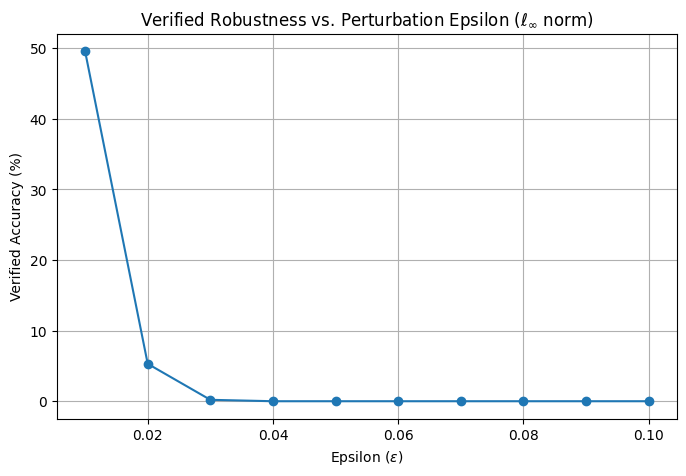

In [8]:
# --- 4. Execution and Plotting ---

epsilons = np.linspace(0.01, 0.1, 10)
eps_values = []
acc_values = []

print("\n--- Running Manual IBP Robustness Verification ---")

# Run verification on the specialized model
for epsilon in epsilons:
    # We pass the verification_model wrapper, which contains the LogitNet
    verified_acc = verify_robustness(verification_model, test_loader, epsilon)
    eps_values.append(epsilon)
    acc_values.append(verified_acc)
    print(f"Verifying for epsilon={epsilon:.3f}... Verified Accuracy: {verified_acc:.2f}%")

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(eps_values, acc_values, marker='o')
plt.title('Verified Robustness vs. Perturbation Epsilon ($\ell_\infty$ norm)')
plt.xlabel('Epsilon ($\epsilon$)')
plt.ylabel('Verified Accuracy (%)')
plt.grid(True)
plt.show()